Perkenalan 
1. Nama: Muhammad Zukri Al Walidani
2. Batch :007
3. Phase: 1

Import Pustaka

In [117]:
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

Input data

In [27]:
df=pd.read_csv('heart_fai.csv')

Eksplorasi Data Sederhana

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [29]:
df.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1


In [30]:
df.DEATH_EVENT.unique


<bound method Series.unique of 0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64>

Exploratory Data Analisis

In [31]:
y = df.DEATH_EVENT

Jumlah Prediksi Meninggal:  0
Jumlah Prediksi tidak meninggal :  1


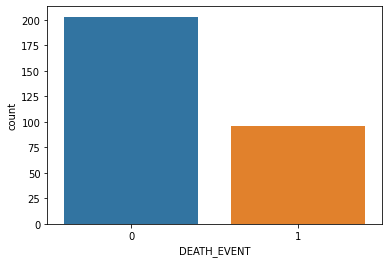

In [35]:
ax = sns.countplot(y,label="Count")   
0, 1 =
= y.value_counts()
print('Jumlah Prediksi Meninggal: ',0)
print('Jumlah Prediksi tidak meninggal : ',1)

prediksi didominasi oleh prediksi hidup (0)

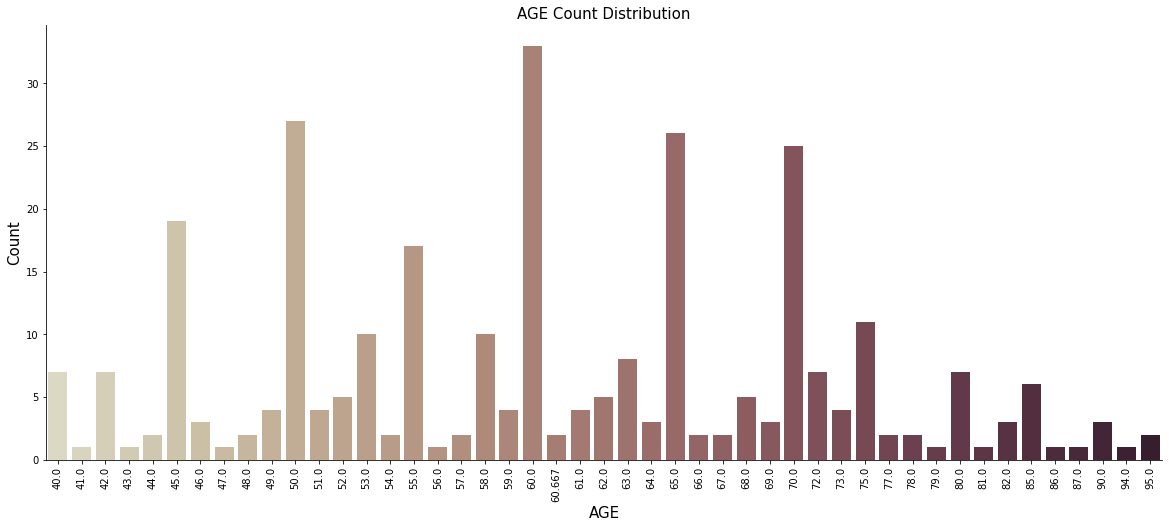

In [47]:
var = 'age'
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
plt.xticks(rotation=90);
sns.countplot(x = var,palette="ch:.4", data =df)
ax.set_xlabel('AGE', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('AGE Count Distribution', fontsize=15)
sns.despine()

Persebaran umur dari 40 hingga 95 tahun

In [57]:
#pengelompokan data numerik dan kategori
numerical_features = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
categorical_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

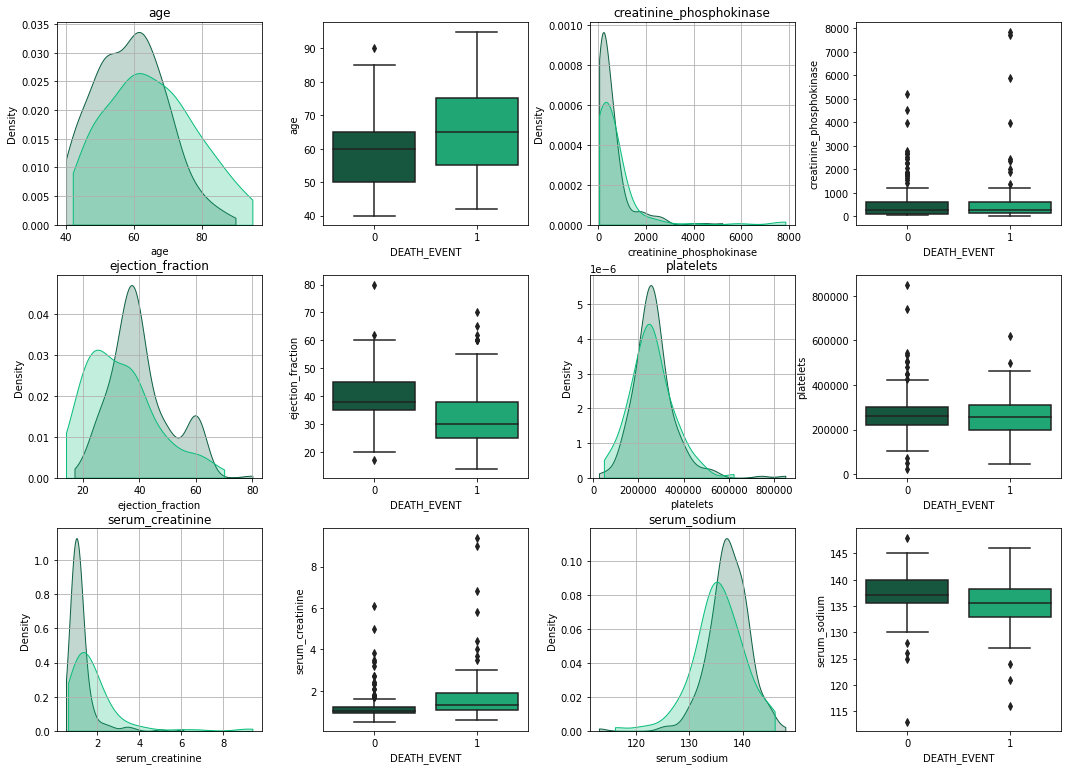

In [67]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(df.loc[df["DEATH_EVENT"]==0, col], label="alive", color = "#0e6142", shade=True, kernel='gau', cut=0)
    sns.kdeplot(df.loc[df["DEATH_EVENT"]==1, col], label="dead",  color = "#08bd7a", shade=True, kernel='gau', cut=0)
    plt.subplot(6, 4, i*2+2) 
    sns.boxplot(y = col, data = df, x="DEATH_EVENT", palette = ["#0e6142", "#08bd7a"])   

1. semakin tinggi usia semakin besar kemungkinan untuk diprediksi meninggal
2. semakin lancar peredaran darah, kemungkinan hidup lebih tinggi.
3. jumlah serum kreatin dalam darah lebih banyak akan memperbesar kemungkinan meninggal
4. jumlah serum sodium dalam darah lebih banyak akan memperbesar kemungkinan hidup

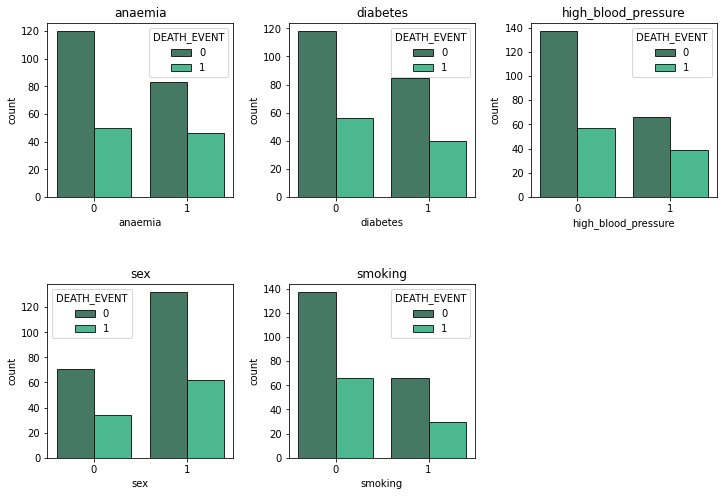

In [65]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue="DEATH_EVENT", palette = ["#0e6142", "#08bd7a"], alpha=0.8, edgecolor="k", linewidth=1)

1. pasien anaemia lebih memiliki kemungkinan kehidupan dari yang tidak menderita (walaupun tipis)
2. pasien diabetes lebih memiliki kemungkinan kehidupan dari yang tidak menderita
3. pasien dengan tekanan darah tinggi lebih memiliki kemungkinan kemarian dibandingkan dengan tekanan darah normal
4. perbandingan angka kematian dan gender sama.
5. perbandingan angka kematian dan status perokok atau tidak adalah sama.

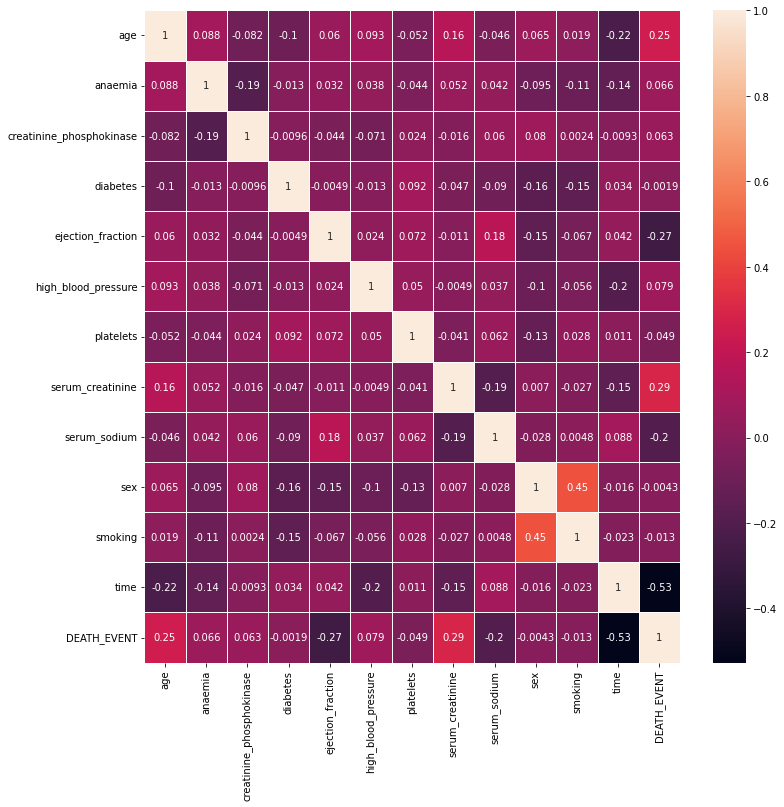

In [62]:
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(),annot=True, linewidths=.5, ax=ax)
plt.show()

1. setiap variabel berkorelasi dengan dirinya sendiri
2. variabel-variabel memiliki korelasi yang rendah, yang paling tinggi yaitu ejection fraction

Feature Engineering

Handling Outliers

In [144]:
numerical_features=["creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
for cols in numerical_features:
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1     

    filter = (df[cols] >= Q1 - 1.5 * IQR) & (df[cols] <= Q3 + 1.5 *IQR)
    df=df.loc[filter]

Text(0.5, 1.0, 'serum_sodium')

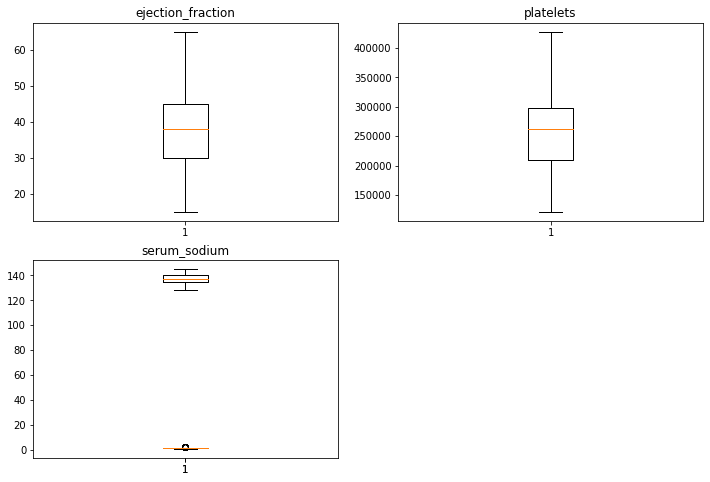

In [143]:
plt.figure(figsize=(12, 8))
ax=plt.subplot(221) 
plt.boxplot(df["ejection_fraction"])
ax.set_title("ejection_fraction")
ax=plt.subplot(222)
plt.boxplot(df["platelets"])
ax.set_title("platelets")
ax=plt.subplot(223)
plt.boxplot(df["serum_creatinine"])
ax.set_title("serum_creatinine")
plt.boxplot(df["serum_sodium"])
ax.set_title("serum_sodium")

Fitur importance

In [145]:
from sklearn.ensemble import ExtraTreesClassifier
X=df.drop(['DEATH_EVENT','time'],axis=1)
y=df.DEATH_EVENT

model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

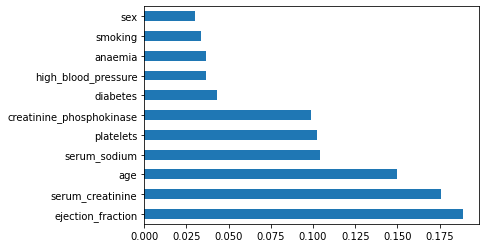

In [100]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

Splitting dan Train

In [106]:
random_state = 11
X=df.drop(['sex','DEATH_EVENT'],axis=1)
y=df.DEATH_EVENT

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=1)
print("Input Training:",X_train.shape)
print("Input Test:",X_test.shape)
print("Output Training:",y_train.shape)
print("Output Test:",y_test.shape)

Input Training: (173, 11)
Input Test: (44, 11)
Output Training: (173,)
Output Test: (44,)


Scaling

In [109]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

Model Random Forest Classifier 

Best K Value is  {'n_estimators': 80}
test accuracy:  0.9090909090909091


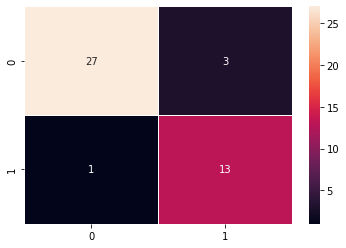

In [125]:
accuracy_list = []
algorithm = []
predict_list = []
param_grid = {'n_estimators': np.arange(10, 100, 10)}
rf = RandomForestClassifier(random_state = 42)
rf_gscv = GridSearchCV(rf, param_grid, cv=4)
rf_gscv.fit(X_train, y_train)
print("Best K Value is ",rf_gscv.best_params_)

print("test accuracy: ",rf_gscv.score(X_test,y_test))
accuracy_list.append(rf_gscv.score(X_test,y_test))
algorithm.append("Random Forest Classifier")

cm = confusion_matrix(y_test,rf_gscv.predict(X_test))
predict_list.append(cm.item(0)+cm.item(2))
sns.heatmap(cm,annot=True, linewidths=.5)
plt.show()

In [128]:
accuracy_list = []
algorithm = []
predict_list = []
param_grid = {'n_estimators': np.arange(10, 100, 10)}
rf = RandomForestClassifier(random_state = 80)
rf_gscv = GridSearchCV(rf, param_grid, cv=4)
rf_gscv.fit(X_train, y_train)
print("Best K Value is ",rf_gscv.best_params_)

print("test accuracy: ",rf_gscv.score(X_test,y_test))
accuracy_list.append(rf_gscv.score(X_test,y_test))
algorithm.append("Random Forest Classifier")

Best K Value is  {'n_estimators': 50}
test accuracy:  0.9090909090909091


Model Gradient Boosting Classifier

The best parameters are  {'learning_rate': 0.075, 'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
------------------------------------------------------
test accuracy is  0.8636363636363636


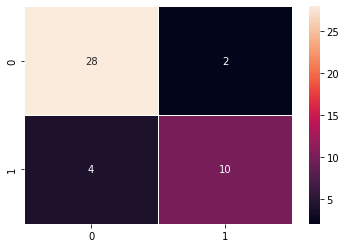

In [131]:
param_grid = {'n_estimators': [10,20,50],'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],'max_features': [2],'max_depth': [2]}
gb = GradientBoostingClassifier()
gb_gscv = GridSearchCV(gb, param_grid, cv=4)
gb_gscv.fit(X_train,y_train)
print("The best parameters are ",gb_gscv.best_params_)
print("------------------------------------------------------")
print("test accuracy is ",gb_gscv.score(X_test,y_test))
accuracy_list.append(gb_gscv.score(X_test,y_test))
algorithm.append("Gradient Boosting Classifier")

cm = confusion_matrix(y_test,gb_gscv.predict(X_test))
predict_list.append(cm.item(0)+cm.item(2))
sns.heatmap(cm,annot=True, linewidths=.5)
plt.show()

In [146]:
param_grid = {'n_estimators': [50],'learning_rate': [0.075],'max_features': [2],'max_depth': [2]}
gb = GradientBoostingClassifier()
gb_gscv = GridSearchCV(gb, param_grid, cv=4)
gb_gscv.fit(X_train,y_train)
print("The best parameters are ",gb_gscv.best_params_)
print("------------------------------------------------------")
print("test accuracy is ",gb_gscv.score(X_test,y_test))
accuracy_list.append(gb_gscv.score(X_test,y_test))
algorithm.append("Gradient Boosting Classifier")


The best parameters are  {'learning_rate': 0.075, 'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
------------------------------------------------------
test accuracy is  0.8409090909090909


Model Inference

In [140]:
#membuat data baru
X_ex= np.random.randint(10, size=(1456292,11))

Model Random Forest Classifier

In [141]:
y_predrfc = rf_gscv.predict(X_ex)
y_predrfc

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

Model Gradien Boosting

In [142]:
y_gb_gscv = gb_gscv.predict(X_ex)
y_gb_gscv

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Kesimpulan:
1. Hubungan korelasi antara variabel cenderung rendah
2. Pasien dengan tekanan darah tinggi lebih memiliki kemungkinan kemarian dibandingkan dengan tekanan darah normal
3. Semakin lancar peredaran darah, kemungkinan hidup lebih tinggi (ejection_fraction)
4. feature importance yang paling tinggi adalah ejection_fraction
5. Setelah melakukan permodelan data dengan Model Random Forest Classifier dan MOdel Gradien Boosting didapatkan hasil Model Random Forest Clasifire mendapatkan tes akurasi yang lebih tinggi yaitu 0.90. artinya Model Random Forest lebih bisa meprediksi data ini.